**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)
<div style="width: 45%; margin: 0 auto; height: 10px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>
<h1 style="text-align:center;">Corner and edge detection</h1>
<div style="width: 45%; margin: 0 auto; height: 15px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>

In this notebook I will try to go over some elementary image detection. For now it has corner and edge detection algorithms, and hopefully hopefully soon will add some contour detection, maybe some sift and more.

# Python initialization

In [1]:
# For some latex printing
! pip install --upgrade --no-cache-dir --force-reinstall git+https://github.com/TotallyReal/MathVisuals.git

  Cloning https://github.com/TotallyReal/MathVisuals.git to c:\users\eofir\appdata\local\temp\pip-req-build-zkihkbhk
  Resolved https://github.com/TotallyReal/MathVisuals.git to commit 56079226f487aae9673ac9bf7725d3bf791d2c19
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for math_visuals: filename=math_visuals-0.1-py3-none-any.whl size=2865 sha256=16d44ca62dbd3fb18d0e3978bfc07261377b4e4b2e770be68a2a2b5cde1fd5df
  Stored in directory: C:\Users\eofir\AppData\Local\Temp\pip-ephem-wheel-cache-eg1w5x99\wheels\fd\70\f2\ffdf707d9d095964589050e0dd0a4b6dd5650388fdc4313e02
Successfully built math_visuals
  Attempting uninstall: math_visuals
    Found existing installation: math_visuals 0.1
    Uninsta

  Running command git clone --filter=blob:none --quiet https://github.com/TotallyReal/MathVisuals.git 'C:\Users\eofir\AppData\Local\Temp\pip-req-build-zkihkbhk'

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.signal import convolve2d
import sys
import os
import math_visuals
from math_visuals import latex

project_root = os.path.abspath("..")  
if project_root not in sys.path:
    sys.path.append(project_root)

import filters
import visualization

import importlib
importlib.reload(filters)
importlib.reload(visualization)

<module 'visualization' from 'C:\\Users\\eofir\\PycharmProjects\\ai\\vision\\visualization.py'>

## Load images

In [3]:
image_path = 'images/alice.png'
image_path = 'images/castle.jpg'
image_path = 'images/chess.jpg'
image = mpimg.imread(image_path)
image_gray = np.mean(image,axis=2)

# fig, axes = plt.subplots(1,2, figsize=(10,5))
# axes[0].imshow(image)
# axes[1].imshow(image_gray, cmap='gray')
# plt.show()

---
# Edge detection
![chess edges](images/chess_edges.png)

## On edges and derivatives

Our first goal is to learn how to detect edges in pixelated images, namely when "one type of area" changes into another. As usual, instead of jumping into the 2D world of images, we start with a much simpler example of dimension 1:

![first derivative](images/smooth_edge.png)

As always, "take the derivative and compare to zero" is the standard move whenever we don't know what to do, and here it works as well. The more the derivative is close to zero, the more $f$ is close to being constant. On the other way around, when $|f'(x)|$ is large we expect a jump in the function. 

Before we add a dimension, let's think about the pixelated 1D version first. Instead of a real function, we have a sequences:
$$F=(..., f(-2), f(-1), f(0), f(1), f(2), ...).$$
### Question:
> What is a discrete derivative?

The standard derivative is defined by 
$$f'(x) =\lim_{h\to 0} \frac{f(x+h)-f(x)}{h}, $$
and a simple discrete approximation is just
$$f'(x) \sim \frac{f(x+1)-f(x)}{1} = f(x+1)-f(x). $$

So it is not too surprizing that we would define a "discrete derivative" as simply $F'(n)=f(n+1)-f(n)$. This seems natural enough, however it is a bit unbalanced: why should we look right at $f(n+1)$ instead of left at $f(n-1)$, and define $F'(n)=f(n)-f(n-1)$? There should be no reason to choose one over the other. Indeed, we can see it on the definition of the derivative itself: if $a,b\in \mathbb{R}$ are distinct, then you should check that
$$f'(x) =\lim_{h\to 0} \frac{f(x+ah)-f(x+bh)}{(a-b)h}.$$

The original definition had $a=1, b=0$, the second one had $a=0, b=-1$, and we can even symmetrize it with $a=1, b=-1$ to get a "new definition" of $$F'(n)=\frac{1}{2}(f(n+1)-f(n-1)).$$

We can even take $a=2, b=-2$ to obtain
$$F'(n)=\frac{1}{4}(f(n+2)-f(n-2)).$$

Going even crazier, the average of these two "definitions" also converge to the dertivative, so why not define:
$$F'(n)=\frac{1}{8}(f(n+2)+2f(n+1)-2f(n-1)-f(n-2)).$$

### Remark:
Historically, the "discrete derivatives" came before the actual derivative, since it took a while until **calculus** was well defined enough for that. As we can see above, while the derivative itself needs a more complicated definition than its "discrete" analouge, in return we get that all its different definitions are actually equivalent, which makes it much more powerful.

With this intuition in mind, a **discrete derivative** at a point $n$ is a **choice** of such finite combination of $f(n+k)$:
$$\sum_{|k|<d} w_k f(n + k)$$
where the weights need to satisfy:
1) Their sum is zero: $\sum w_k = 0$.
2) Their weighted sum should be one: $\sum w_k \cdot k = 1$.
    - In some cases, we only care about the direction of the derivative, or maybe only compare derivative using ratios, in which case this weighted
      sum condition can be changed to only be positive. For example, under this new condition we might scale the weights to be
      integers, making the computations easier.
    - Exercise: These conditions are the same for the standard derivative.
3) We usually choose a simmetric combination: $w_k = -w_{-k}$.
4) The smaller $|k|>0$ is, the larger $w_k$ should be, to give larger weight to values closer to the point of derivative.

## Discrete derivative and convolution

Discrete derivative like $F'(n)=f(n+1)-f(n-1)$ can be represented in a very simple and interesting way. To compute the element $F'(n)$, we "write" down all the sequence of $f(k)$, and above the $n$ index put a "window" with $(-1,0,1)$:

|$\cdots$|0|0|-1|0|+1|0|0|$\cdots$|
|---|---|---|---|---|---|---|---|---|
|$\cdots$|f(n-3)|f(n-2)|f(n-1)|f(n) |f(n+1)|f(n+2)|f(n+3)|$\cdots$|

If we want to compute $F(n+1)$ we simply slide the window one step to the right, and for $F(n-1)$ one step to the left etc.

This is true for the other choices of discrete derivatives, and this type of combination of translations appear often enough and in enough places to get a name:

### Definition: Convolution (on $\mathbb{Z}$)

> Let $f,g:\mathbb{N}\to\mathbb{R}$ be two sequences. We define their **convolution** to be the sum (whenever it is well defined):
> $$(f*g)(n) = \sum_{k\in \mathbb{Z}}f(n+k)g(-k).$$

Note that if one of these sequences has only finitely many nonzero values, the sum in the convolution is always finite and therefore well defined.

### Example:

1. The function $F_1(n)=f(n+1)-f(n-1)$ is the convolution $f*g_1$ where:
   $$g_1(k)=\cases{-1 & k=1 \\ +1 & k=-1 \\ 0 & else}$$
2. Similarly, the function $F_2(n)=f(n+2)+2f(n+1)-2f(n-1)-f(n-2)$ is the convolution $f*g_2$ where:
   $$g_2(k)=\cases{-1 & k=2 \\ -2 & k=1 \\ +2 & k=-1 \\ +1 & k=-2 \\ 0 & else}$$
3. We can average each position with its two neighbors, namely $F_3(n)=\frac{f(n-1)+f(n)+f(n+1)}{3}$, and again write is as a convolution $F_3=f*g_3$:
   $$g_3(k)=\cases{\frac{1}{3} & k=-1,0,1 \\ 0 & else}$$


Many more interesting operations can be viewed as convolutions. Whenever we want to get a new function where its $n$-th value depends only on a local environment of $n$ (which will be the case in our computer vision algorithms), then usually it will be a convolution.

### Remark:
> While a bit less intuitive, note that the "direction" of the window is reverse. Namely, instead of having $(-1,0,+1)$ as in the example at the beginning of this section, we actually have $(+1,0,-1)$. This is because in the definition we had the product $f(n+k)g(-k)$ instead of $f(n+k)g(+k)$.
> This choice was not done just to confuse us, but actually it is the more natural choice. Think for example on the most well known convolution - if you multiply two polynomials, then the coefficients of the resulting polynomial are convolutions of the coefficients of the polynomial factors. As example, consider all the ways you can write $x^3$ as a product of two monomials:
> $$x^0\cdot x^3 , x^1 \cdot x^2 , x^2\cdot x^1 , x^3\cdot x^0.$$
> Alternaticely, these are exactly $x^{3+k} x^{-k}$ for $k=0,1,2,3$.
>
The intuition above from polynomial multiplication is actually much more than just intuition: **convolution is multiplication** under the right settings. Thus, (almost) everything you expect from multiplication is true here as well, e.g.:
1. **Associativity**: $f*(g*h)=(f*g)*h$
2. **Linear**: $(\alpha\cdot f+g)*h=\alpha\cdot f*h+g*h$.
3. **commutative**: $f*g=g*f$
4. **unit**: $f=f*\delta_0=\delta_0*f$ where $\delta_0(x)=\cases{1 & x=0\\0 &else}$.

## Implementing convolution 1D

Writing the convolution function should be an easy exercise, which you should make sure that you can solve.

The fact that all the computations for each $n$ are done "similarly" means that a good use of math libraries and GPUs can run this convolutions quite fast. One library that already implements this convolution is [**`scipy.signal.convolve`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).
Unlike the theoretical convolution above, in our algorithms we deal with only finite sequences. This raises some problems when our convolution window move over the edge of the sequence. For example, if we want to take the discrete derivative as above, but for a sewquence of length 5:

|$\cdots$|0|0|0|0|0|-1|0|+1|0|$\cdots$|
|---|---|---|---|---|---|---|---|---|---|---|
|$\cdots$|**?**|**?**|f(-2)|f(-1)|f(0) |f(+1)|f(+2)|**?**|**?**|$\cdots$|

There are several solutions to this problem, like:
1. Fill the rest of the infinite sequence (the missing '**?**') with zeros.
2. More generally, use special formulas to compute the boundary.
3. Only convolve inside the finite sequence.

The first solution adds information which doesn't nessecarily is part of the data (think that we take an image, but say that everything outside of it is just black). The second doesn't formally adds information, but in a sense breaks the pattern of the convolution. Finally, the third solution doesn't add new information, but it means that the resulting sequence will be shorter.

In any case, we see that we have some problems along the boundary of our data. Usually when the image is very large compared to the convolution window, we barely notice this problem, but you should remember that it exists. In particular, the `mode` parameter in **`scipy.signal.convolve`** more or less detemines what happens along this boundary.

## Going 2D

When going to dimension 2, we want to measure the derivative in some direction, which we formally call a [**directional derivative**](https://en.wikipedia.org/wiki/Partial_derivative):
$$\frac{\partial f}{\partial v} := v_x \cdot \frac{\partial f}{\partial x} + v_y \cdot \frac{\partial f}{\partial y} = \left\langle{v,\nabla f}\right\rangle.$$

It becomes a little bit tricikier when we talk about **discrete derivatives** on our pixelated images, since not all direction are equal. We usually only consider the main two direction along the $x$ and $y$ axes, namely $(1,0),(0,1)$, and sometimes the two diagonal direction $(1,1),(1,-1)$. Once we have these derivative, we can use the gradient formula to compute discrete derivatives in every direction if needed.

Here too, the computation is done using convolution with 2d filters:

In [4]:
from math_visuals import latex
from math_visuals.latex import latex_print

for name, (dx, dy) in filters.edge_derivatives.items():
    print(f'{name}:')
    latex_print(f'dx = {latex.matrix_latex(dx)}  ;  dy = {latex.matrix_latex(dy)}')

Roberts:


<IPython.core.display.Math object>

Prewitt:


<IPython.core.display.Math object>

Sobel3:


<IPython.core.display.Math object>

Sobel5:


<IPython.core.display.Math object>

Once we choose our discrete derivative, we can compute them at the $x$ and $y$ directions (or in the Roberts' case, the diagonal directions), and use it to define the discrete gradiant. We can then look at the size of the gradient, and the larger it is, to more likelyhood that we have an edge.

In [5]:
visualization.show_edge_derivatives(image_gray)

# Using Laplacians

## Some geometric intuition

We are used to think about the "Laplacian" as the second derivative. Indeed, we use second derivatives to compute the laplacian, however they are not the same. But before explaining it, let's understand how the second derivative helps us with edge detection.
![derivatives](images/derivatives.png)

Looking at the first derivative's absolute value $|f'(x)|$, the higher it is, the faster the rate of change, the more "edgier" the function is. On the other hand, $f'(x)\sim 0$ means that $f$ is almost constant.

The second derivative similarly indicates the change rate of the first derivative. As can be seen in the example above, we see a spike before and after the edge, but is zero in the "edge point" itself. More precisely $f''(x)\sim 0$ when $f$ is almost linear. We can see this both when $x<-1$ and when $1<x$, since the function is almost constant zero there. At $x=0$ the function again is very close to being linear, while in between it is much curvier and closer to an actual parabola than a line.

In dimension 2, by definition the Laplacian is
$$\Delta f=\frac{\partial^2f}{\partial x^2}+\frac{\partial^2f}{\partial y^2}.$$

Here too, if we start with a linear function $f(x)=ax+by+c$, then clearly $\Delta f = 0$, and more generally if $f$ is "close" to being linear, then its Laplacian is close to being 0. However, there are other nonlinear function with zero Laplacians, which by definition are called **harmonic functions**. For exmplae, there is the harmonic function $e^x\sin(y)$ which don't look linear at all:

<p align="center"><img src="images/harmonic.png" width="500"/></p>

Characterizing Harmonic function geometrically is not as simple as in dimension 1, however, they do have an interesting property:
> **If $f$ is harmonic, then its value at $x$ is the average of its values around $x$**.

This is something that we already expect from linear functions. For example, if you take this simple linear sequence:
$$1,2,3,4,5,6,... ,$$
then every number is the average of its two neighbors. For example $4=\frac{1}{2}(3+5)$.

We shall soon apply it to our image, and see how this average of neighborhood come into play there.

### Remark
> I am still not convinced that the Laplcian is truly helpful in edge detection, say more than using gradients. However, it is commonly used for that, and it is important in general, so I all go over it too.

## Image Laplacian

In discrete 2D images, we define Laplacian similarly: We want the Laplacian at a point to be zero if it is the average of its neighbors. There are of course several choices of how to do averages, which we control using weights on the neighboring pixels. For example:

In [6]:
for name, lap_filter in filters.edge_laplacians.items():
    print(f'{name}:')
    latex.latex_print(f'{latex.matrix_latex(lap_filter)}')

4 directions:


<IPython.core.display.Math object>

8 directions:


<IPython.core.display.Math object>

As mentioned above, the Laplacian of the image will be close zero whenever the image is close to being "harmonic" (the pixel is the average of its neighbors). In particular this holds when it is close to being linear, which include being constant. Since the values of the Laplacian can be both positive and negative, we can view instead the **absolute value** of the result, so that black regions are where the Laplacian is close to zero.

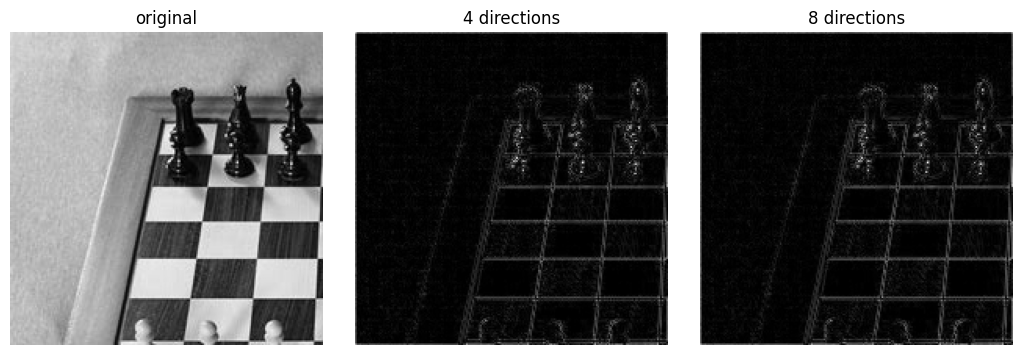

In [7]:
visualization.show_edge_laplacian(image_gray[:200,:200])

As can be seen, along the edges we actually get two white lines, since on the edges itself the image is close to linear, and therefore the Laplacian is close to 0.

The edges here are less clear than they were with the gradient edge detection. One of the reasons is that the random noise starts to impact more and more, the more derivatives that we take. Indeed, in its very nature, the derivative is a ratio of two small numbers, so even a little bit of noise can greatly affect it. One way to go around it, is to first blur a little bit the image and then take the Laplacian (or derivatives in general). Yes, we lose some of the details, but also a lot of the noise.

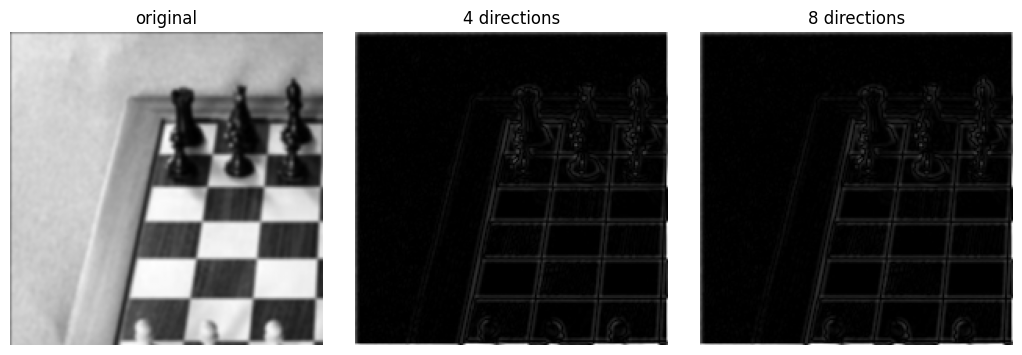

In [8]:
blurred_image = convolve2d(image_gray, filters.binomial_blur2d(5), mode='same', boundary='fill', fillvalue=0)
visualization.show_edge_laplacian(blurred_image[:200,:200])

# Harris corner detector

An interesting Youtube video on this subject: [First Principles of Computer Vision](https://www.youtube.com/watch?v=Z_HwkG90Yvw&list=PL2zRqk16wsdqXEMpHrc4Qnb5rA1Cylrhx&index=7&ab_channel=FirstPrinciplesofComputerVision).

The main idea:
- consider a small window around some pixel. If this window contains a corner, it contains two edges in independent directions.
- We can view this property in the set of discrete gradients:
  - **No edges**: Most gradients are near the origin.
  - **Only parallel edges**: Most gradients are near the same line.
  - **Corner**: Gradients are near (at least) two independent lines.

Let's see three such examples from our chess image:

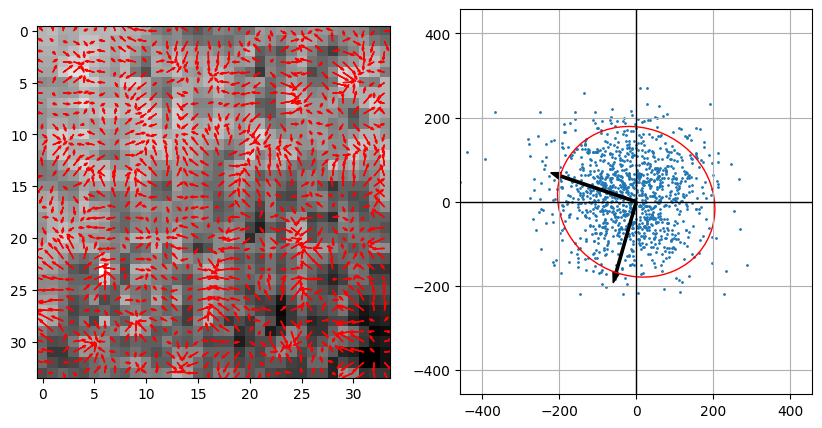

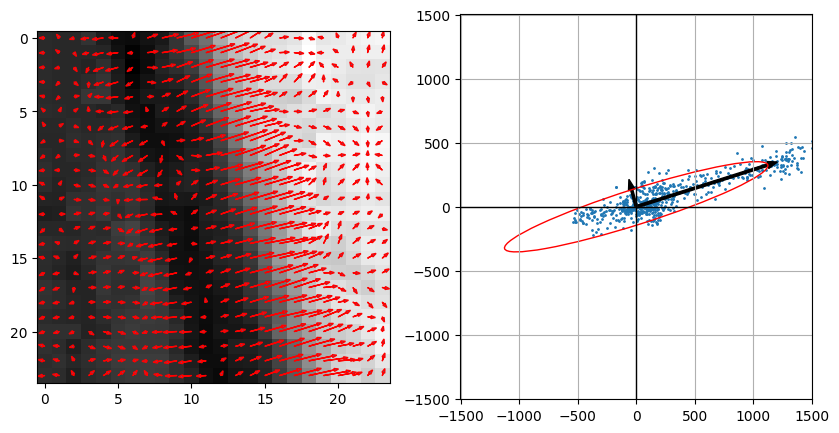

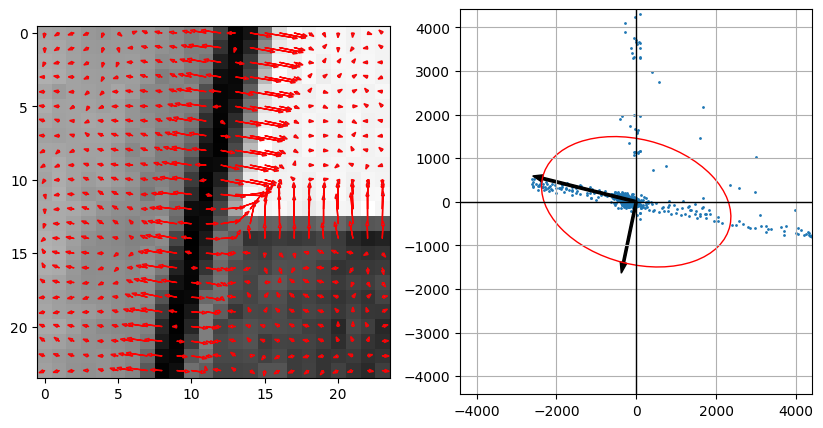

In [9]:
visualization.show_harris_corner_gradients(image_gray[0:40, 0:40], filters.edge_derivatives['Sobel5'])
visualization.show_harris_corner_gradients(image_gray[120:150, 410:440], filters.edge_derivatives['Sobel5'])
visualization.show_harris_corner_gradients(image_gray[105:135, 70:100], filters.edge_derivatives['Sobel5'])

We can measure this using the same ideas as in [principal component analysis](fashion_mnist/pca.md). Indeed, if we have at most parallel edges, this means that we can project the data into a 1D line without losing too much information. Formally, there are no edges when both eigenvalues are small, parallel edges when just one eigenvalue is large, and a corner of both are large.

<p align="center"><img src="images/harris_corner_regions.png" width="300"/></p>

More specifically, let $W$ is our window, and $\nabla f=(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y})$ is some choice of discrete derivatives. We define the matrix $A_W$ to be the $|W|\times 2$ matrix where the rows correspond to the discrete gradients inside the window. Then, we consider the $2\times 2$ following matrix and its eigenvalues:
$$M_W := A_W^T \cdot A_W.$$

### Remark:

>If we want, we can add weights to the position in the window. For example, higher weights for position closer to the center. In this case, our matrix will be $A_W^T D A_W$ where $D$ is diagonal with the weight on the diagonal.

How can we measure how deep in the "corner" region are we? This is usually does via the expression:
$$R=\lambda_1 \cdot \lambda_2-k(\lambda_1+\lambda_2)^2 = \det(M_W)-k(tr(M_W))^2,$$
where $k\in [0.04, 0.06]$ is very small. To understand this expression, we can do the standard analysis of quadratic forms, and note that it is actually better to work with the basis $\lambda_1+\lambda_2, \lambda_1-\lambda_2$ rather than $\lambda_1,\lambda_2$. In particular, you can check that the expression above is equivalent to 

$$4R+\left(\lambda_1-\lambda_2\right)^{2}=\left(1-4k\right)\left(\lambda_1+\lambda_2\right)^{2}.$$

Note that $1-4k \sim 0.8 > 0$ is positive, so for each $R$ we get a hyperbola. For example, for $k=0.05$ we get:

<p align="center"><img src="images/harris_hyperbolas.png" width="300"/></p>

So for $R=0$ we get two lines, as as $R$ increases, we get hyperbolas with these lines as asymptotes. In other words, the bigger $R$ is, the more "cornery"  the region looks like. Note that the range of values of the original picture can vary (e.g. in $[0,127]$, or $[0,255]$ or even real numbers in $[0,1]$) and affect what it means for $R$ to be big, and similarly the choice of the discrete gradient. One way to circumvent it is to normalize all the "corneriness" values that we get at the end to be in $[0,1]$, and then say that a point is a corner if it is greater than some value (e.g. $0.5$).

So in total our algorithm is :

1. **Input**:
    1. A grayscale $n\times m$ image, represented by the function $f(i,j)$.
    2. Window size, preferably small and odd, e.g. 3, 5, 7, etc.
    3. Value for $k$ in $[0.04, 0.06]$.
3. **Compute discrete gradients**: for each point $\nabla f(i,j)=(f_x(i), f_y(i))$.
4. **Quadratics**: Move to triples $(f_x(i)^2, f_x(i)\cdot f_y(i), f_y(i)^2)$.
5. **Sliding windows**: Sum the triples over windows. Let $A(i,j),B(i,j),C(i,j)$ be the corresponding sums. This allows us to define the matrix
   $$M^{(i,j)} = \pmatrix{A & B \\ B & C}.$$
6. **Corner weight**: Compute
   $$R(i,j) = \det(M^{(i,j)})-k\cdot tr(M^{(i,j)})^2 = A(i,j)\cdot C(i,j)-B(i,j)^2-k\cdot (A(i,j)+B(i,j))^2$$
7. **Normalize**: Map $R$ linearly to be in $[0,1]$ with min and max being 0 and 1 respectively.

### Remark:
As always, when using sliding windows on images, there is the issue with the boundry which you should decide what to do there.

### Example: Simple square

Let's look on a simple white square on a black background. We compute the corners with the **Sobel3** gradients, and window size 5 to obtain. We mark the pixels with corner weight $>0.5$ in red, and those which are also local maxima in yellow.

In [10]:
from scipy.ndimage import maximum_filter

def plot_harris_corners(image_gray:np.ndarray, window_size: int = 5, threshold: float = 0.5):
    corner_weights = filters.harris_weight(image_gray, filters.edge_derivatives['Sobel3'], window_size=window_size)
    max_positions = (corner_weights == maximum_filter(corner_weights, size=5, mode='constant', cval=-np.inf))
    local_max = max_positions * corner_weights
    
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(image_gray, cmap='gray')
    y, x = np.where(corner_weights > threshold)
    axes[0].scatter(x, y, c="red", s=7) 
    axes[0].set_title('corner positions')
    y, x = np.where(local_max  > threshold)
    axes[0].scatter(x, y, c="yellow", s=5) 
    
    axes[1].imshow(corner_weights, cmap='gray')
    axes[1].set_title('corner weights')
    axes[2].imshow(local_max, cmap='gray')
    axes[2].set_title('corner maxima')
    
    plt.show()

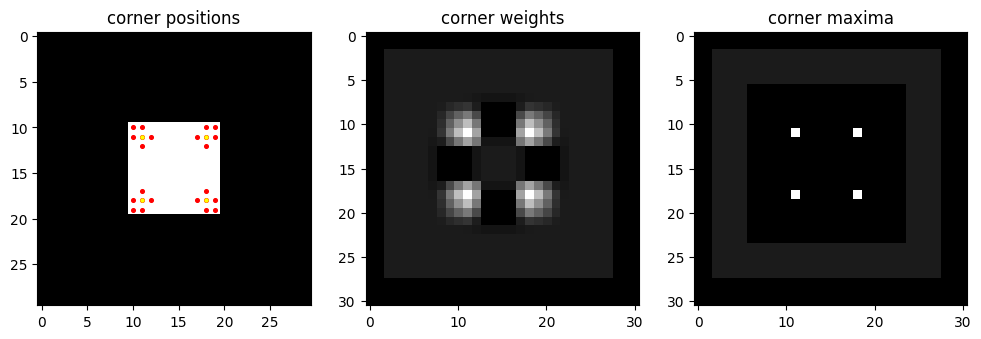

In [11]:
square_image = np.zeros((30,30))
square_image[10:20,10:20] = 1
plot_harris_corners(square_image, 5)

It is interesting to note that the "best" corner according to this computation, is actually **not** what we consider the corner pixel, but instead on pixel towards the inside of the square. This is because it "sees" more edges, both horizontal and vertical, so it is more "cornery" relative to the actual pixel in the actual corner. 

### Example: Two nearby corners

This time we take a slightly more complicated shape. Furthermore, in each corner "region" we will plot in yellow only the pixel with the highest weight.

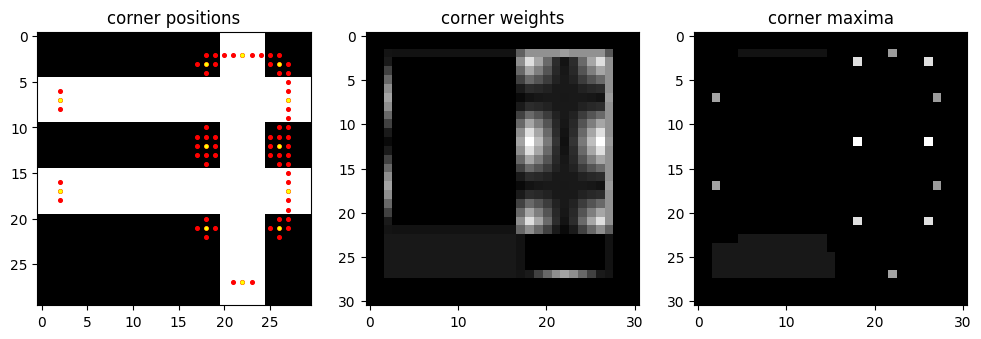

In [12]:
complicated_image = np.zeros((30,30))
complicated_image[5:10,:] = 1
complicated_image[15:20,:] = 1
complicated_image[:,20:25] = 1
plot_harris_corners(complicated_image, 5)

There are 2 issues we should note here:
1. In the middle black row, we see that the "best" corner pixel is actually in the middle and not near the corners. This is because in a window size = 5, this pixel can see two corners. More over, its corner weight is so large, that after normalization, the actual pixels in the corners have too small weight (here below 0.5) to be considered corners.
2. We see "new corners" near the boundary of the image. These are not actual corner, but artifacts arising from auto completing the outside of the image with black color.

### Example: Real image

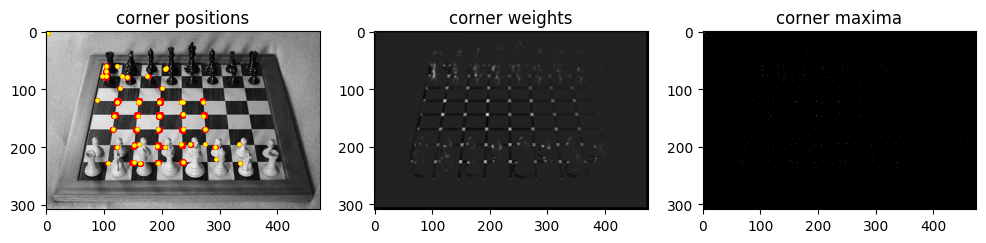

In [13]:
plot_harris_corners(image_gray, 5, threshold = 0.5)

Not all the "natural" corners of the chess board were indicated. We can see in the corner weight image that their weight are high enough to be seen, but they are less than the threshold. This is because the right side of the board is darker, so the difference between the squares is smaller. Reducing the threshold will add them to the list of corners.